### 2. Laurie's Books Customer Cohort Analysis
Here we take cleaned transaction data and develop cohorts based on recency, frequency, monetary value, and tenure.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

In [2]:
df = pd.read_csv('transactions_cleaned.csv', parse_dates=['date'])

In [3]:
df.head()

,uid,order_no,date,qty,price,genre,author
0,6390785,10005,2023-09-22,1,5.0,American History,"Sandford, John"
1,6390785,10005,2023-09-22,1,5.0,American History,"Sandford, John"
2,6390785,10005,2023-09-22,1,5.0,American History,"Sandford, John"
3,6390785,10005,2023-09-22,1,5.0,American History,"Sandford, John"
4,6390785,10005,2023-09-22,1,5.0,American History,"Sandford, John"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5708 entries, 0 to 5707
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   uid       5708 non-null   int64         
 1   order_no  5708 non-null   int64         
 2   date      5708 non-null   datetime64[ns]
 3   qty       5708 non-null   int64         
 4   price     5708 non-null   float64       
 5   genre     5689 non-null   object        
 6   author    5402 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 312.3+ KB


Make helper functions

In [5]:
def get_month(x):
    return datetime(x.year, x.month, 1)

def get_date_int(df, column):
    return df[column].dt.year, df[column].dt.month, df[column].dt.day

In [6]:
# Create a column with the invoice month
df['inv_mo'] = df.date.apply(get_month)

In [7]:
# Check whether all transactions were grouped into the available months
df.inv_mo.unique()

<DatetimeArray>
['2023-09-01 00:00:00', '2023-10-01 00:00:00', '2023-11-01 00:00:00',
 '2023-12-01 00:00:00', '2024-01-01 00:00:00', '2024-02-01 00:00:00']
Length: 6, dtype: datetime64[ns]

In [8]:
# Create a grouping to get the first month the customer made a purchase
grouping = df.groupby('uid')['inv_mo']
df['cohort_mo'] = grouping.transform('min')

In [9]:
# Get the first and last purchase dates
df['last_date'] = df.groupby('uid')['date'].transform('max')
df['first_date'] = df.groupby('uid')['date'].transform('min')

In [10]:
# Get the integers for date parts from the Invoice Month column
invoice_year, invoice_month, invoice_day = get_date_int(df, 'inv_mo')

# Get the integers for date parts from the Cohort Month column
cohort_year, cohort_month, cohort_day = get_date_int(df, 'cohort_mo')

# Get the integers for days from the date column
join_day = df.date.dt.day

In [11]:
# Develop a cohort index from the difference
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# This represents the months of this purchase since their first purchase
df['month_idx'] = years_diff * 12 + months_diff + 1

# This represents the days of this purchase since their first purchase
df['day_idx'] = years_diff * 365 + months_diff * 30 + join_day

In [12]:
df.sample(n=5)

,uid,order_no,date,qty,price,genre,author,inv_mo,cohort_mo,last_date,first_date,month_idx,day_idx
4634,99350956,11578,2024-02-05,1,5.0,Mystery,"Woods, Stuart",2024-02-01,2023-11-01,2024-02-16,2023-11-03,4,100
2829,73000488,10962,2023-12-13,1,5.0,Mystery,"Kellerman, Faye",2023-12-01,2023-10-01,2024-01-26,2023-10-07,3,73
4686,74435098,11593,2024-02-06,1,4.0,Mystery,"Woods, Stuart",2024-02-01,2023-10-01,2024-02-21,2023-10-11,5,131
2839,25033823,10966,2023-12-14,1,3.0,Mystery,"Whiddon, Karen",2023-12-01,2023-12-01,2023-12-14,2023-12-14,1,14
173,83918759,10090,2023-09-27,1,4.0,Westerns,"West, Joseph A.,Compton, Ralph",2023-09-01,2023-09-01,2023-09-27,2023-09-27,1,27


In [13]:
# Counting monthly customers
grouping = df.groupby(['cohort_mo', 'month_idx'])
cohort_data = grouping['uid'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index='cohort_mo',
                                  columns='month_idx',
                                  values='uid')

In [14]:
cohort_counts

month_idx,1,2,3,4,5,6
cohort_mo,,,,,,
2023-09-01,85.0,25.0,26.0,17.0,26.0,15.0
2023-10-01,219.0,43.0,46.0,43.0,46.0,NaN
2023-11-01,164.0,23.0,23.0,33.0,NaN,NaN
2023-12-01,140.0,12.0,19.0,NaN,NaN,NaN
2024-01-01,131.0,20.0,NaN,NaN,NaN,NaN
2024-02-01,150.0,NaN,NaN,NaN,NaN,NaN


### Develop cohort metrics

In [15]:
# Create a retention matrix
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [16]:
# This shows us the percent of customers that shopped in subsequent months
retention.round(3) * 100

month_idx,1,2,3,4,5,6
cohort_mo,,,,,,
2023-09-01,100.0,29.4,30.6,20.0,30.6,17.6
2023-10-01,100.0,19.6,21.0,19.6,21.0,NaN
2023-11-01,100.0,14.0,14.0,20.1,NaN,NaN
2023-12-01,100.0,8.6,13.6,NaN,NaN,NaN
2024-01-01,100.0,15.3,NaN,NaN,NaN,NaN
2024-02-01,100.0,NaN,NaN,NaN,NaN,NaN


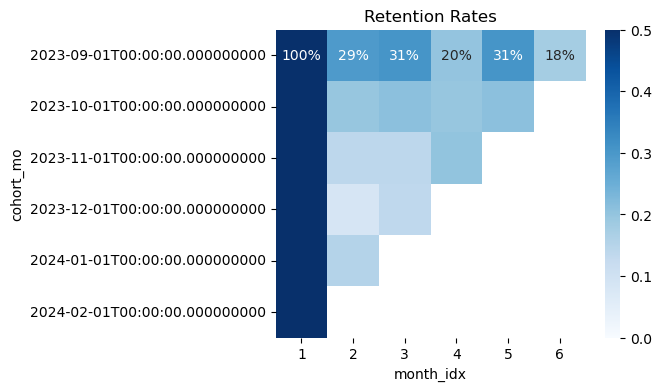

In [17]:
# Visualize that matrix
plt.figure(figsize=(5, 4))
plt.title('Retention Rates')
sns.heatmap(data=retention,
            annot=True,
            fmt='.0%',
            vmin=0.0,
            vmax=0.5,
            cmap='Blues')
plt.show()

### Recency, Frequency, Monetary Value Analysis

In [18]:
# Create a DataFrame to analyze spending
spending = df[['uid', 'qty', 'price']]

In [19]:
# Create a column for total spending per transaction
spending = spending.assign(total = spending.qty * spending.price)

In [20]:
# Group the transactions by customer
monetary_value_data = spending[['uid', 'total']].groupby('uid').sum().reset_index()

In [21]:
# Create quartiles
monetary_value_data['mv_quartile'] = pd.qcut(monetary_value_data['total'], q=4, labels=range(1,5))

In [22]:
monetary_value_data.sample(5)

,uid,total,mv_quartile
166,17910262,144.45,4
183,20240530,49.49,4
362,40187150,3.50,1
576,66702580,48.50,3
250,28216605,2.50,1


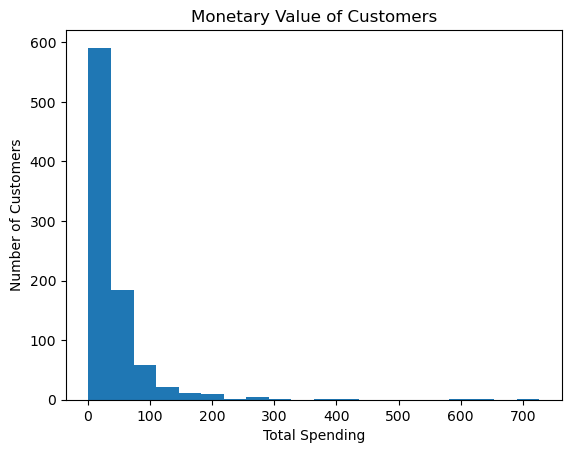

In [23]:
# Visualize the distribution of spending
plt.hist(monetary_value_data.total, bins=20)
plt.title('Monetary Value of Customers')
plt.xlabel('Total Spending')
plt.ylabel('Number of Customers')
plt.show()

In [24]:
# This makes a table of customers and date since their most recent purchase
recency_data = df[['uid', 'first_date', 'last_date']].drop_duplicates(subset=['uid'])

In [25]:
# Calculate the number of days since their first (i.e., tenure) and last purchase
recency_data['days_since_last'] = (pd.to_datetime('3/1/2024') - recency_data['last_date']) / np.timedelta64(1, 'D')
recency_data['tenure'] = (pd.to_datetime('3/1/2024') - recency_data['first_date']) / np.timedelta64(1, 'D')

In [26]:
recency_data.sample(5)

,uid,first_date,last_date,days_since_last,tenure
139,3627006,2023-09-26,2024-01-10,51.0,157.0
3833,99800222,2024-01-12,2024-01-12,49.0,49.0
882,3951200,2023-10-19,2024-02-01,29.0,134.0
92,53869371,2023-09-25,2024-01-19,42.0,158.0
5639,68030599,2024-02-28,2024-02-28,2.0,2.0


In [27]:
# Create quartiles for recency
recency_data['recency_quartile'] = pd.qcut(recency_data['days_since_last'], q=4, labels=list(range(4, 0, -1)))

In [28]:
# Create descriptive customer quartile labels
r_labels = ['Regular', 'Occasional', 'Infrequent', 'Inactive']
recency_data['recency_label'] = pd.qcut(recency_data['days_since_last'], q=4, labels=r_labels)

In [29]:
recency_data.sample(5)

,uid,first_date,last_date,days_since_last,tenure,recency_quartile,recency_label
1381,11400998,2023-11-03,2023-11-03,119.0,119.0,1,Inactive
4543,4854678,2024-02-02,2024-02-02,28.0,28.0,3,Occasional
4222,36056873,2024-01-26,2024-01-26,35.0,35.0,3,Occasional
1460,11324355,2023-11-07,2023-11-07,115.0,115.0,1,Inactive
4188,78888128,2024-01-25,2024-01-25,36.0,36.0,3,Occasional


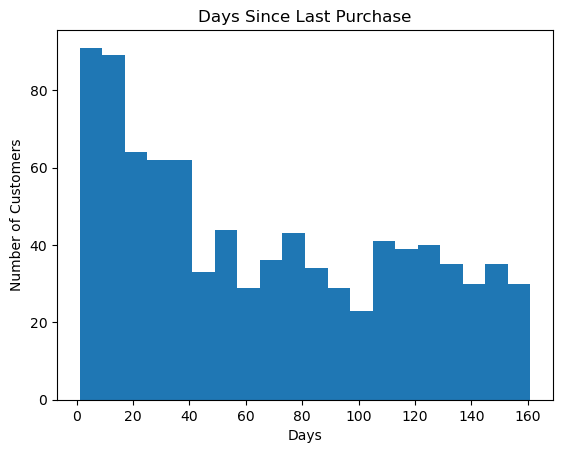

In [30]:
plt.hist(recency_data.days_since_last, bins=20)
plt.title('Days Since Last Purchase')
plt.xlabel('Days')
plt.ylabel('Number of Customers')
plt.show()

In [31]:
# Create a column for number of transactions
frequency_data = df[['uid', 'order_no']].drop_duplicates(subset='order_no').groupby('uid').count().reset_index()

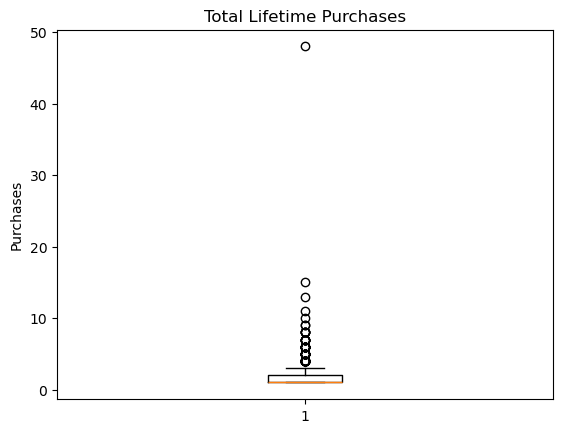

In [32]:
plt.boxplot(frequency_data.order_no)
plt.title('Total Lifetime Purchases')
plt.ylabel('Purchases')
plt.show()

Because there are more than half the customers who have a single purchase, we can't do quartiles. It would cause the first and second quartile to overlap at 1. Instead, we'll do bins with ranges we eyeball. 

In [33]:
# Create bins with breaks at 1, 3, 10, and the max
frequency_data['frequency_quartile'] = pd.cut(frequency_data.order_no, bins=[0,1,3,10,50], labels=range(1, 5))

In [34]:
frequency_data.frequency_quartile.value_counts()

frequency_quartile
1    595
2    209
3     81
4      4
Name: count, dtype: int64

We see that nearly 90% of the customers have three or less transactions across the 5 months of data. 

In [35]:
# Combine recency, freqency, and monetary value for summary statistics
rf_data = pd.merge(recency_data[['uid', 'days_since_last', 'recency_quartile']], 
                   frequency_data[['uid', 'order_no', 'frequency_quartile']], on='uid')
rfm_data = pd.merge(rf_data, monetary_value_data[['uid', 'total', 'mv_quartile']], on='uid')

In [36]:
rfm_data = rfm_data.rename(columns={'recency_quartile': 'R',
                                    'order_no': 'transactions',
                                    'frequency_quartile': 'F',
                                    'total': 'total_spending',
                                    'mv_quartile': 'M'})

In [37]:
rfm_data.sample(5)

,uid,days_since_last,R,transactions,F,total_spending,M
578,49179897,71.0,2,1,1,9.99,1
805,64852577,16.0,4,1,1,22.99,2
808,68449209,14.0,4,1,1,14.49,2
730,56732405,31.0,3,1,1,11.00,1
694,82314156,30.0,3,2,2,108.98,4


In [38]:
# Write a function to concatinate the values of RFM as a string for segmentation
def join_rfm(x): return str(int(x.R)) + str(int(x.F)) + str(int(x.M))

In [39]:
# Create segments and scores
rfm_data['RFM_segment'] = rfm_data.apply(join_rfm, axis=1)
rfm_data['RFM_score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)

In [40]:
rfm_data.sample(5)

,uid,days_since_last,R,transactions,F,total_spending,M,RFM_segment,RFM_score
556,25997644,62.0,2,2,2,104.21,4,224,8
233,71577296,132.0,1,1,1,26.50,3,113,5
265,59522683,128.0,1,1,1,3.00,1,111,3
522,57556178,80.0,2,1,1,107.00,4,214,7
457,38970566,41.0,3,4,3,86.99,4,334,10


##### Analyze Segments

In [41]:
# View the top 10 most common segments
rfm_data.groupby('RFM_segment').size().sort_values(ascending=False)[:10]

RFM_segment
111    83
112    63
211    60
212    49
213    43
311    43
312    40
434    38
411    35
424    35
dtype: int64

In [42]:
# Group the scores
rfm_data.groupby('RFM_score').agg({
    'days_since_last': 'mean',
    'transactions': 'mean',
    'total_spending': ['mean', 'count']}).round(1)

days_since_last transactions total_spending      
                     mean         mean           mean count
RFM_score                                                  
3                   136.0          1.0            7.7    83
4                   111.7          1.0           12.8   123
5                    85.4          1.1           18.4   139
6                    59.2          1.1           27.0   144
7                    52.0          1.4           34.8   120
8                    34.3          1.9           46.3    94
9                    25.8          2.3           68.9    79
10                   22.5          4.1          100.0    66
11                    9.2          5.9          164.1    38
12                    3.7         13.0          245.7     3

In [43]:
# Function to segment into gold, silver, or bronze
def segment_me(df):
    if df['RFM_score'] >= 9:
        return 'Gold'
    elif df['RFM_score'] >= 5:
        return 'Silver'
    else: 
        return 'Bronze'

In [44]:
# Apply the labels
rfm_data['general_segment'] = rfm_data.apply(segment_me, axis=1)
# Show the table
rfm_data.groupby('general_segment').agg({
    'days_since_last': 'mean',
    'transactions': 'mean',
    'total_spending': ['mean', 'count']}).round(1)

days_since_last transactions total_spending      
                           mean         mean           mean count
general_segment                                                  
Bronze                    121.5          1.0           10.8   206
Gold                       20.8          3.9          102.3   186
Silver                     60.1          1.3           30.1   497

##### Postprocess for clustering

In [45]:
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   uid              889 non-null    int64   
 1   days_since_last  889 non-null    float64 
 2   R                889 non-null    category
 3   transactions     889 non-null    int64   
 4   F                889 non-null    category
 5   total_spending   889 non-null    float64 
 6   M                889 non-null    category
 7   RFM_segment      889 non-null    object  
 8   RFM_score        889 non-null    int64   
 9   general_segment  889 non-null    object  
dtypes: category(3), float64(2), int64(3), object(2)
memory usage: 51.8+ KB


In [46]:
# Save out the segments for later deanonymizing
rfm_data[['uid', 'general_segment']].to_csv('lauries_general_segments.csv', index=False)

In [47]:
# Create a Tenure DataFrame
tenure_data = recency_data[['uid', 'tenure']].drop_duplicates(subset='uid')

In [48]:
# Collect relevant columns, add in tenure
cluster_data = pd.merge(rfm_data[['uid', 'days_since_last', 'transactions', 'total_spending']], 
                        tenure_data[['uid', 'tenure']], on='uid')

In [49]:
cluster_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uid              889 non-null    int64  
 1   days_since_last  889 non-null    float64
 2   transactions     889 non-null    int64  
 3   total_spending   889 non-null    float64
 4   tenure           889 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.9 KB


In [50]:
cluster_data.to_csv('customers_for_clustering.csv', index=False)